## Build pretraining text data

1. We want to build a large pretraining text file.
2. we then want to build a tokenizer from this.

We have the 

In [5]:
import glob

# provide path to the main document folder

tei_files = glob.glob("/Users/mv96/Downloads/ACM_Multimedia/dest-pdfs/*/*.tei.xml")
len(tei_files)

381

# Training the tokenizer from scratch

In [7]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import os

# make the txt files from all the tei xmls
# for tei in tqdm(tei_files):


def write_text_file(tei):
    txt_name = tei.replace(".tei.xml", ".txt")
    if os.path.exists(txt_name):
        return "exists"
    else:
        with open(tei, "r") as f:
            contents = f.read()
            soup = BeautifulSoup(contents, "xml")
            # get the title
            try:
                title = soup.title.get_text()
            except:
                return "error reading the content"

            # get the abstract ready
            abstract = soup.abstract
            p_tags = abstract.find_all("p")
            abstract_constructed = ""
            for tag in p_tags:
                abstract_constructed += tag.get_text()
            # print(abstract_constructed)
            # print("="*50)

            # get the body ready

            body = soup.body
            all_tags = body.find_all(["p", "note", "formula", "head"])
            body_constructed = []
            for tag in all_tags:
                extract_text = ""
                for sub_tag in tag:
                    extract_text = extract_text + " " + sub_tag.get_text()
                body_constructed.append(extract_text)

            # get the back
            back = soup.back
            all_tags = back.find_all(["p", "note", "formula", "head"])
            back_constructed = []
            for tag in all_tags:
                extract_text = ""
                for sub_tag in tag:
                    extract_text = extract_text + " " + sub_tag.get_text()
                back_constructed.append(extract_text)

        f.close()

        # write the abstract body and back of the xml to the pdf

        with open(txt_name, "w") as f:
            # write title
            f.write(title + "\n")
            # write abstract
            f.write(abstract_constructed + "\n")
            # write body
            for bd in body_constructed:
                f.write(bd + "\n")
            # write title
            for bk in back_constructed:
                f.write(bk + "\n")
            f.close()

        return "success"


from joblib import Parallel, delayed

res = Parallel(n_jobs=-2, prefer="threads")(
    delayed(write_text_file)(tei) for tei in tqdm(tei_files)
)


100%|█████████████████████████████████████████| 381/381 [00:17<00:00, 21.43it/s]


# getting the vocabulary

In [ ]:
# compare the vocabulary with scibert/ bert and distilbert
import glob
import time
import os

txt_files = glob.glob(
    "/Volumes/My_Book/Theoremkb/cluster_package/5-grobid_on_pdfs/ftest/*/*.txt"
)

In [ ]:
# move the txt_files to a new folder
from tqdm import tqdm
import shutil

text_files_path = "/Volumes/My_Book/Theoremkb/cluster_package/text_files"
if not os.path.exists(text_files_path):
    os.mkdir(text_files_path)

for i, file in enumerate(tqdm(txt_files)):
    name_of_file = file.rsplit("/", 1)[1]
    destination = os.path.join(text_files_path, "{}.txt".format(i))
    # print(destination)
    # if destination does not exist only then copy
    shutil.copyfile(file, destination)

In [ ]:
print(len(txt_files))

In [ ]:
file

In [10]:
# compare vocabs of other models
import json
import os


tokenizer = "tokenizer-2.json"
path_to_vocab = "./vocabularies"
skips = ["./vocabularies/trained_bpe/tokenizer-2.json"]

vocabs = {}
for folder in os.listdir(path_to_vocab):
    if os.path.isfile(folder):
        continue
    else:
        tokenizer_path = os.path.join(path_to_vocab, folder, tokenizer)
        if tokenizer_path in skips:
            continue

        # Opening JSON file
        try:
            f = open(tokenizer_path)
        except:
            continue
        # returns JSON object as
        # a dictionary
        data = json.load(f)
        vocab = list(data["model"]["vocab"].keys())
        f.close()
        vocabs[folder] = vocab

In [11]:
vocabs.keys()

dict_keys(['scibert_scivocab_uncased', 'distilbert-base-cased', 'trained_tokenizer', 'bert-base-uncased', 'distilbert-base-uncased', 'scibert_scivocab_cased', 'bert-base-cased'])

In [12]:
def calc_overlap(k1, k2, vocabs):
    if k1 == k2:
        # print("same name given")
        return 1
    set_1 = set(vocabs[k1])
    set_2 = set(vocabs[k2])
    intersects = set_1.intersection(set_2)
    unions = set_1.union(set_2)
    return len(intersects) / len(unions)

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

# visualize heat maps

vocab_names = list(vocabs.keys())
final_matrix = []
for vocab in vocab_names:
    matrix = []
    for remain in vocab_names:
        overlap = calc_overlap(vocab, remain, vocabs)
        matrix.append(overlap)
    final_matrix.append(matrix)

final_df = pd.DataFrame(final_matrix, columns=vocab_names, index=vocab_names)

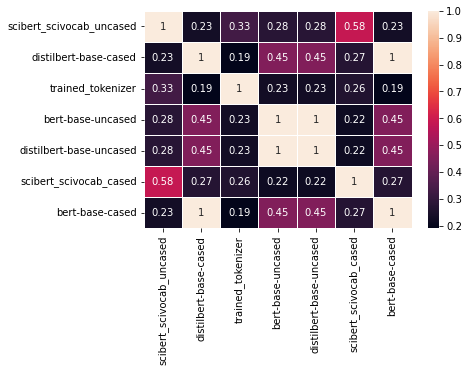

In [23]:
ax = sns.heatmap(final_df, linewidth=0.5, annot=True)
plt.savefig("heatmap.svg", format="svg")
plt.show()

In [ ]:
for vocab in vocabs.keys():
    print(vocab, len(vocabs[vocab]))

In [15]:
from tokenizers import BertWordPieceTokenizer
from tokenizers import ByteLevelBPETokenizer

merged_text_file_path = "/Users/mv96/Downloads/full_text_data.txt"
# Initialize a tokenizer
tokenizer = BertWordPieceTokenizer()

tokenizer.train(
    files=merged_text_file_path,
    vocab_size=30522,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
    show_progress=True,
)

In [27]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer = BertWordPieceTokenizer(
    "./Kantai/vocab.txt",
)

text = """Corollary 1. Let m 􏰮 k, and PS be a distribution over Rm×n satisfying Assumption 1 . Then,
E ∥∆T ∥2 =
Proof. The proof of Theorem 1 is deferred to Appendix A.1 .
 t=0
foranyT􏰮0,theminimumerrorE∥∆T∥2isobtainedbychoosingμt=θ1 forall0􏰭t<T.
Consequently,"""

In [29]:
tokenizer.encode(text).tokens

['[CLS]',
 'corollary',
 '1',
 '.',
 'let',
 'm',
 'k',
 ',',
 'and',
 'ps',
 'be',
 'a',
 'distribution',
 'over',
 'rm',
 '##×n',
 'satisfying',
 'assumption',
 '1',
 '.',
 'then',
 ',',
 'e',
 '∥∆',
 '##t',
 '∥2',
 '=',
 'proof',
 '.',
 'the',
 'proof',
 'of',
 'theorem',
 '1',
 'is',
 'deferred',
 'to',
 'appendix',
 'a',
 '.',
 '1',
 '.',
 't',
 '=',
 '0',
 'for',
 '##any',
 '##t0',
 ',',
 'them',
 '##ini',
 '##m',
 '##umer',
 '##ro',
 '##re',
 '##∥',
 '##∆t',
 '##∥',
 '##2',
 '##iso',
 '##bt',
 '##ained',
 '##by',
 '##ch',
 '##oo',
 '##sing',
 '##μ',
 '##t',
 '=',
 'θ1',
 'forall',
 '##0t',
 '<',
 't',
 '.',
 'consequently',
 ',',
 '[SEP]']

In [ ]:
import os

text_files_path = "/Volumes/My_Book/Theoremkb/cluster_package/text_files"
text_files_path = [
    os.path.join(text_files_path, txt) for txt in os.listdir(text_files_path)
]

In [ ]:
filenames = text_files_path

from tqdm import import os
token_dir = '/content/KantaiBERT'
if not os.path.exists(token_dir):
  os.makedirs(token_dir)
tokenizer.save_model('KantaiBERT')
with open("/Volumes/My_Book/Theoremkb/cluster_package/full_text_data.txt", "w") as outfile:
    for filename in tqdm(filenames):
        with open(filename) as infile:
            try:
                contents = infile.read()
            except UnicodeDecodeError:
                continue
            outfile.write(contents)